# Absorption Spectra and Screening

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../src/")

import read_files
import utils
import absorption

In [2]:
run = "300ps_2fs"

LHII_data = read_files.all_LHII_data(run, 3000, True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.43it/s]
150000it [00:31, 4822.28it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.01it/s]


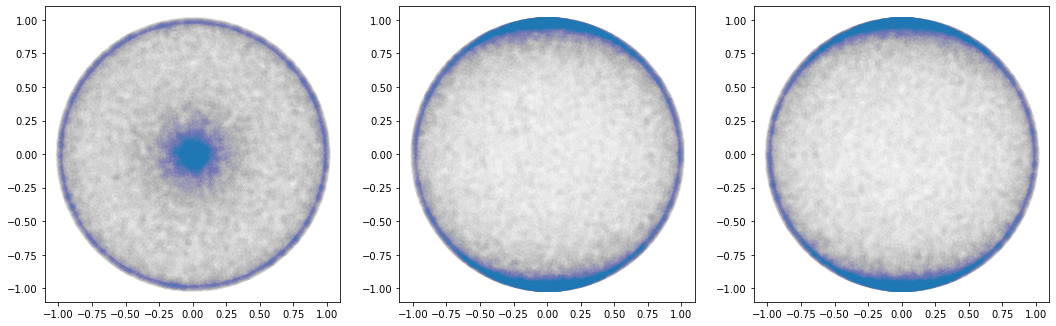

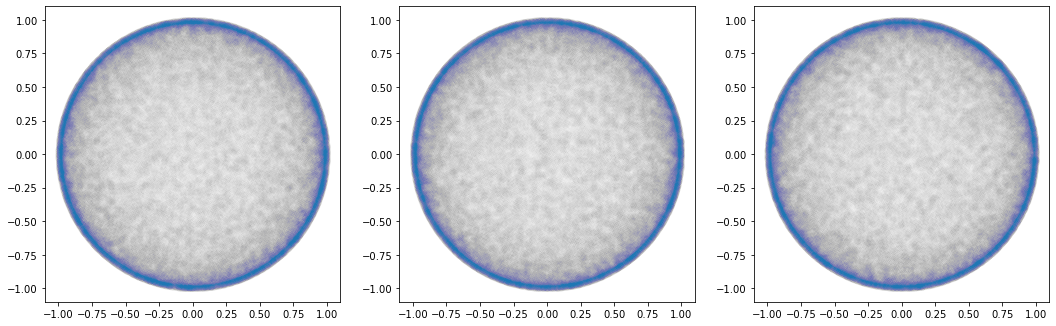

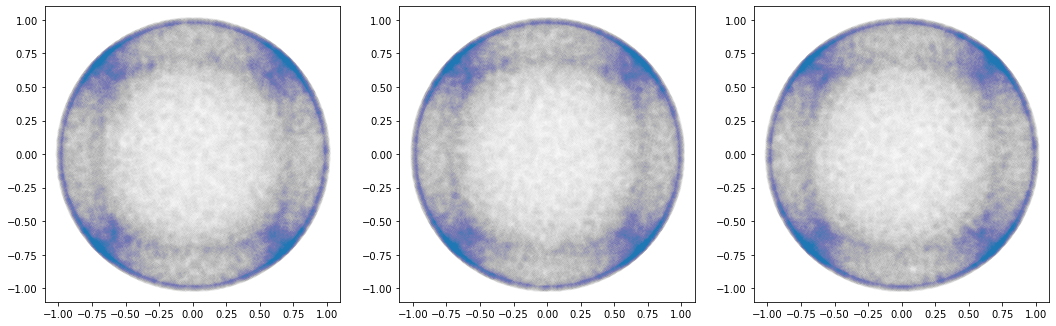

In [3]:
temp = utils.random_unit_vectors_polar(100000)

fig, ax = plt.subplots(1, 3)
ax[0].scatter(temp[:, 0], temp[:, 1], alpha=0.005)
ax[1].scatter(temp[:, 0], temp[:, 2], alpha=0.005)
ax[2].scatter(temp[:, 1], temp[:, 2], alpha=0.005)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.set_size_inches(18, 6)

temp = utils.random_unit_vectors(100000)

fig, ax = plt.subplots(1, 3)
ax[0].scatter(temp[:, 0], temp[:, 1], alpha=0.005)
ax[1].scatter(temp[:, 0], temp[:, 2], alpha=0.005)
ax[2].scatter(temp[:, 1], temp[:, 2], alpha=0.005)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.set_size_inches(18, 6)

temp = utils.random_unit_vectors_uniform(100000)

fig, ax = plt.subplots(1, 3)
ax[0].scatter(temp[:, 0], temp[:, 1], alpha=0.005)
ax[1].scatter(temp[:, 0], temp[:, 2], alpha=0.005)
ax[2].scatter(temp[:, 1], temp[:, 2], alpha=0.005)

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.set_size_inches(18, 6)

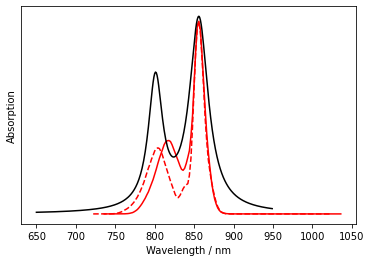

In [12]:
fig, ax = plt.subplots()

absorption.reference(LHII_data["eigval"], LHII_data["dipoles"], LHII_data["eigvec"], ax, 856, args={"color" : "red"})
absorption.trial_screening(LHII_data["distances"], LHII_data["hamils"], LHII_data["dipoles"], 0., 0., 1.4, ax, 856, args={"color" : "red", "linestyle" : "--"})
absorption.plot_experimental(ax, args={"color" : "black"})

ax.set_ylabel("Absorption")
ax.set_yticks([])

ax.set_xlabel("Wavelength / nm")

plt.savefig("../images/absorption_spectra.png")


In [13]:
def plot_density(vecs, ax):
    density = np.square(vecs)
    avg_dens = np.mean(density, axis=0)

    b800 = list(range(1, 27, 3))
    b850a = list(range(2, 27, 3))
    b850b = list(range(3, 27, 3))

    ax.imshow(avg_dens[1:, 1:][b800+b850a+b850b], cmap='YlGn')

    return avg_dens[1:, 1:][b800+b850a+b850b]

In [10]:
screened_states, screened_eigvecs = absorption.screen_hamiltonians(LHII_data["distances"], LHII_data["hamils"], 0., 0., 1.4)

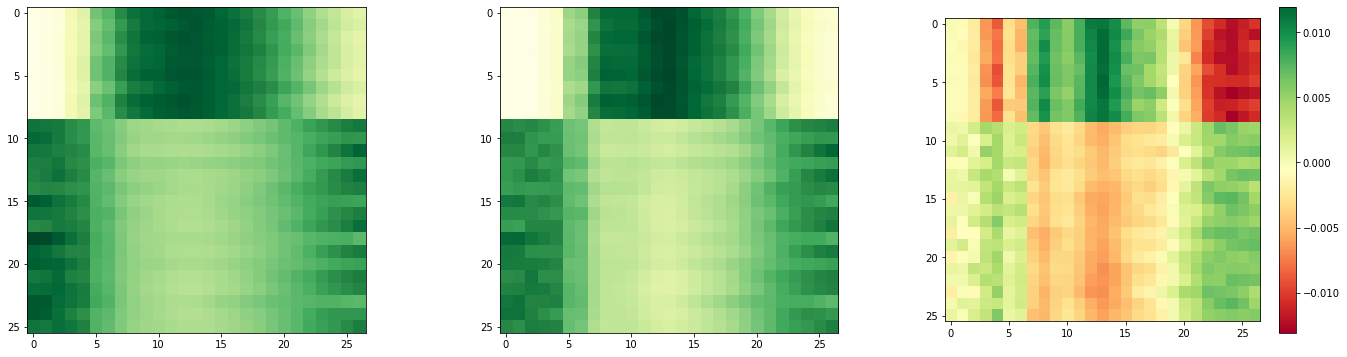

In [14]:
fig, ax = plt.subplots(1, 3)

a = plot_density(LHII_data["eigvec"], ax[0])
b = plot_density(screened_eigvecs, ax[1])
cax = ax[2].imshow(b-a, cmap='RdYlGn')

fig.colorbar(cax)
fig.set_size_inches(24,6)

plt.savefig("../images/screened_density_diff.png")